# Datapipeline:

WARNING:

+ For the script to work the data files must be positiong in the data path of the repository. 
Or the path to the data must be adapted accordingly. In this script all data must be in data_path 
+ The *Data which is used : EU_all_current_shared.parquet* from Andreas preprocession.

Import the necessary libraries 

0. Load the Data 

* Load the data from a specified file using the appropriate function.
* Save the loaded data into a variable (called df) for further use.

1. Main data pipeline 
Treat data to reach a point were we have the data frame ready for the separate treatments for classification and regression treatment 

* 1.A: Omitting / deleting of variables which have no meaning for the model (explain why)
* 1.B: Omitting / deleting car identifiers because they are not relevant for the model
* 1.C: Omitting data before a certain year (explain why) 
* 1.D: Treatment of outliers (explaing why)
    * Mean for gaussian like data 
    * Other technique for non gaussian distributed data 
* 1.E: Separation into electric cars and non electric cars (explain why)

2. Data pipeline for classification models 
Prepare data so that it can be used for all basic classification models 

* Loading data which has received the first/main data pipeline 
* 
* 
*
* Separation into train and test data 
* Scale data 

3. Data pipeline for regression models 
Prepare data so that it can be used for all basic regression models 

* Loading data which has received the first/main data pipeline 
* 
* 
*
* Separation into train and test data 

4. Evaluation with baseline classification models 

* Create different baselin models 
* Train models 
* Prediction 
* Evaluation / Score 

5. Evaluation with baseline regression models 

* Create different baselin models 
* Train models 
* Prediction 
* Evaluation / Score 



# Importing necessary libraries 

In [1]:
# Import the required libraries 

# Data manipulation and math operations
import pandas as pd
import numpy as np
import pyarrow.parquet as pq  # For working with parquet files

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import seaborn as sns            # For Seaborn visualizations
import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline

# System libraries
import warnings
import os
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Machine Learning libraries
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For encoding categorical variables and scaling features

# Regression model and evaluation
from sklearn.linear_model import LinearRegression  # For linear regression models
from sklearn.metrics import mean_squared_error  # For calculating mean squared error (MSE)

# Libraries for decision tree, random forest, and other machine learning models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # For decision tree models (classification and regression)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # For random forest models (classification and regression)
from sklearn.svm import SVC  # For Support Vector Classification
from sklearn.neighbors import KNeighborsClassifier  # For K-Nearest Neighbors classification
from sklearn.metrics import accuracy_score, classification_report  # For model evaluation (classification metrics)


# 0. Loading Data 

In [3]:
# Importing Data 
# Path to the neighboring 'data' folder
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

# Check the path
print(data_path + '/EU_all_current_shared.parquet')

# Load parquet data
table = pq.read_table(os.path.join(data_path, 'EU_all_current_shared.parquet'))

# Convert to pandas DataFrame
df = table.to_pandas()

/Users/tillo/Repositoriums/aug24_bds_int---co2/data/EU_all_current_shared.parquet


# 0.0 Insepct data functions

In [6]:
def inspect_data(df):
    """
    Function to perform an initial data inspection on a given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to inspect.

    Returns:
    None
    """
    print("Basic Data Overview")
    
    # Print the shape of the DataFrame (rows, columns)
    print("Shape of the dataframe:", df.shape)
    
    # Display the first 5 rows of the dataset
    print("\nFirst 5 rows of the dataframe:")
    print(df.head(5))
    
    # Get information about data types, missing values, and memory usage
    print("\nDataframe information:")
    df.info()
    
    # Show basic statistics for numeric columns
    print("\nSummary statistics of numeric columns:")
    print(df.describe())

inspect_data(df)

Basic Data Overview
Shape of the dataframe: (14442792, 41)

First 5 rows of the dataframe:
         ID Country  VFN              Mp              Mh  \
0  280060.0      UK  NaN             NaN         UNKNOWN   
1  280060.0      UK  NaN             NaN         AUDI AG   
2  280060.0      PL  NaN     VW GROUP PC      VOLKSWAGEN   
3  280060.0      HU  NaN             NaN  HYUNDAI ASSAN    
4  280060.0      HU  NaN  GENERAL MOTORS            OPEL   

                                Man       MMS                  Tan  \
0                           UNKNOWN  VAUXHALL                  NaN   
1                               NaN      AUDI                  NaN   
2                     VOLKSWAGEN AG       NaN  e1*2001/116*0211*27   
3  HYUNDAI ASSAN OTOMOTIV SANAYI VE   Hyundai  e11*2007/46*0192*04   
4                      ADAM OPEL AG      Opel   e1*2007/46*0374*14   

             T       Va  ...  De  Vf Status    year Date of registration  \
0  A-H/MONOCAB     BF11  ... NaN NaN      P  2010.0

In [ ]:
# Define missing values function for future use
def count_missing_values(df):
    missing_counts = {}
    
    for col in df.columns:
        # Count pd.NA and np.nan separately
        pd_na_count = df[col].isna().sum() if df[col].dtype.name == 'category' else 0
        np_nan_count = df[col].isna().sum() if df[col].dtype.name == 'float32' else 0
        
        # Store the results
        missing_counts[col] = {'pd.NA': pd_na_count,
                               'np.nan': np_nan_count,
                               'Dtype': df[col].dtype.name,
                               'Percent Missing': f"{df[col].isna().sum() / len(df[col]) * 100:.2f}%"
                              }

    # Convert the results to a DataFrame for easier viewing
    result_df = pd.DataFrame(missing_counts).T
    return result_df

# Count and display the missing values
result = count_missing_values(df)
print(result)

# 1. Main data pipeline 

# 1.A Drop all data that does not contain target variable Ewltp (g/km)

In [7]:
# Drop rows where all values in 'Ewltp (g/km)' are NaN
df.dropna(subset=['Ewltp (g/km)'], inplace=True)

# 1.B Filtering for years after 2018 
+ appearance of the new WLT measurement of the EU 
+ more trustworthy 
+ VW diesel scandal in 2015 

In [9]:
# Filter rows where year is 2018 or greater
df = df[df['year'] >= 2018]

# Print the shape of the updated DataFrame
print('The shape of the remaining df:')
print(df.shape)

The shape of the remaining df:
(10875961, 41)


# 1.C Declare all columns which should be deleted/omitted, explain why and delete them 

In [13]:
# Delete columns without meaning for the model
print(df.columns)

# List of columns to be dropped because they are pure car identifiers and have no technical meaning
car_identifiers = ['Ve', 'Va', 'T', 'Tan', 'VFN', 'ID']

administrative_values = ['Country', 'Date of registration', 'Status', 'year']

data_related_columns = ['r', '#identical occurences']

brand_related = ['Mp', 'Mh', 'Man', 'MMS']

# Different measurement or to much correlation (fuel consumation)
correlated_with_target = ['Enedc (g/km)','Ernedc (g/km)', 'Erwltp (g/km)','Fuel consumption ']

# Put them together 
list_columns_drop = car_identifiers + administrative_values + data_related_columns + brand_related + correlated_with_target

# Filter only the columns that exist in the DataFrame
existing_columns_to_drop = [col for col in list_columns_drop if col in df.columns]

# Drop the existing columns
if existing_columns_to_drop:
    df.drop(existing_columns_to_drop, axis=1, inplace=True)
    print(f"Dropped columns: {existing_columns_to_drop}")
else:
    print("No columns to drop were found in the DataFrame.")

# Display the updated DataFrame
print(df.columns)

Index(['Mk', 'Cn', 'Ct', 'Cr', 'm (kg)', 'Mt', 'Enedc (g/km)', 'Ewltp (g/km)',
       'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)',
       'z (Wh/km)', 'IT', 'Ernedc (g/km)', 'Erwltp (g/km)', 'De', 'Vf',
       'Fuel consumption ', 'ech', 'RLFI', 'Electric range (km)'],
      dtype='object')
Dropped columns: ['Enedc (g/km)', 'Ernedc (g/km)', 'Erwltp (g/km)', 'Fuel consumption ']
Index(['Mk', 'Cn', 'Ct', 'Cr', 'm (kg)', 'Mt', 'Ewltp (g/km)', 'W (mm)',
       'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)',
       'IT', 'De', 'Vf', 'ech', 'RLFI', 'Electric range (km)'],
      dtype='object')


In [15]:
inspect_data(df)
count_missing_values(df)

Basic Data Overview
Shape of the dataframe: (10875961, 21)

First 5 rows of the dataframe:
             Mk            Cn  Ct  Cr  m (kg)      Mt  Ewltp (g/km)  W (mm)  \
2968982  SUZUKI         SWIFT  M1  M1  1045.0  1151.0         135.0  2450.0   
2968986  SUZUKI         SWIFT  M1  M1   915.0  1051.0         115.0  2450.0   
2968987  SUZUKI         SWIFT  M1  M1   915.0  1051.0         115.0  2450.0   
2969039   SKODA        SUPERB  M1  M1  1560.0     NaN         146.0  2836.0   
2969057     BMW  X2 sDrive18i  M1  M1  1490.0  1578.0         149.0  2670.0   

         At1 (mm)  At2 (mm)  ... Fm ec (cm3)  ep (KW)  z (Wh/km)      IT  De  \
2968982    1510.0    1515.0  ...  M   1373.0    103.0        NaN     NaN NaN   
2968986    1530.0    1530.0  ...  M   1242.0     66.0        NaN     NaN NaN   
2968987    1520.0    1520.0  ...  M   1242.0     66.0        NaN     NaN NaN   
2969039    1578.0    1566.0  ...  M   1968.0    110.0        NaN     NaN NaN   
2969057    1563.0    1562.0  ...  

,pd.NA,np.nan,Dtype,Percent Missing
Mk,2632,0,category,0.02%
Cn,32334,0,category,0.30%
Ct,2500,0,category,0.02%
Cr,48391,0,category,0.44%
m (kg),0,3221,float32,0.03%
Mt,0,379506,float32,3.49%
Ewltp (g/km),0,0,float32,0.00%
W (mm),0,1812025,float32,16.66%
At1 (mm),0,2052671,float32,18.87%
At2 (mm),0,2057328,float32,18.92%


# 1.D Identify electric cars 
+ identify electric (or hybrid) cars by looking at electric range and electric capacity 
+ making separate column whichs marks the non electric cars 
+ fill then all the nan values in electri range and electric capacity with 0 (because they have non, which is equal to 0)
+ ANNOTATION: Open for discussion with the Team 

In [19]:
# If there is a NaN in Electric range or a NaN in z
# Create the Non_Electric column: 1 if both Electric range OR z (Wh/km) are NaN, otherwise 0
df['Non_Electric_Car'] = (df['Electric range (km)'].isna() & df['z (Wh/km)'].isna()).astype(int)

# Fill NaN values in Electric range (km) and z (Wh/km) with 0
df['Electric range (km)'].fillna(0, inplace=True)
df['z (Wh/km)'].fillna(0, inplace=True)

In [20]:
# Display the updated DataFrame
count_missing_values(df)

,pd.NA,np.nan,Dtype,Percent Missing
Mk,2632,0,category,0.02%
Cn,32334,0,category,0.30%
Ct,2500,0,category,0.02%
Cr,48391,0,category,0.44%
m (kg),0,3221,float32,0.03%
Mt,0,379506,float32,3.49%
Ewltp (g/km),0,0,float32,0.00%
W (mm),0,1812025,float32,16.66%
At1 (mm),0,2052671,float32,18.87%
At2 (mm),0,2057328,float32,18.92%


# 1.E Outlier Handling 

# Place gaussian like distribution test here if there is one 

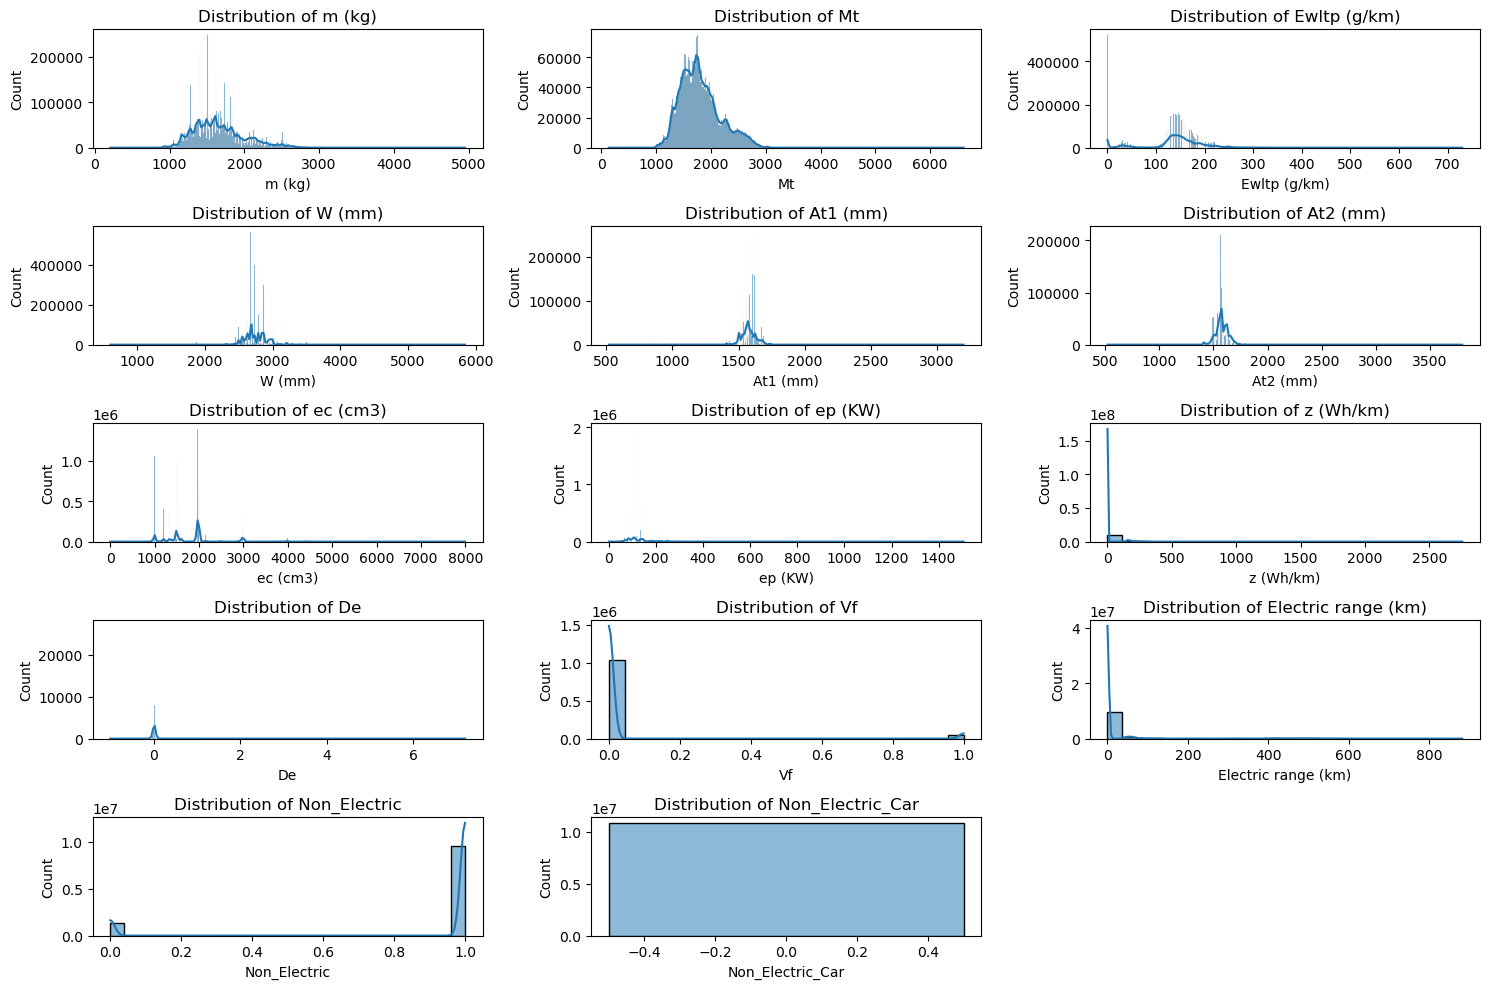

In [23]:
# Linear models assume normality of the data. 
# Instead of performing slow Gaussian-like distribution tests, we will visualize the distributions.

# Select only the numerical columns of type float64, float32, and int64
numb_columns = df.select_dtypes(include=['float64', 'float32', 'int64']).columns

# Plot histograms to visualize the distribution of each numerical column
plt.figure(figsize=(15, 10))  # Set the figure size
for i, column in enumerate(numb_columns, 1):
    plt.subplot(len(numb_columns) // 3 + 1, 3, i)  # Create subplots (3 columns per row)
    sns.histplot(df[column], kde=True)  # Plot histogram with a KDE (Kernel Density Estimate)
    plt.title(f'Distribution of {column}')  # Add title to each subplot
    plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

In [24]:
# Since the near gaussian distribution test is not working I am declaring them by visual: 
gaussian_cols = ['m (kg)', 'Mt',  'W (mm)', 'At1 (mm)', 'At2 (mm)']
non_gaussian_cols = [ 'ec (cm3)', 'ep (KW)']

In [25]:
# Assuming gaussian_cols is already defined (e.g., from the Shapiro-Wilk test)
# Replace outliers in Gaussian-distributed columns with the median value of those columns.

# Calculate the first (Q1) and third (Q3) quartiles for the specified Gaussian columns
Q1 = df[gaussian_cols].quantile(0.25)
Q3 = df[gaussian_cols].quantile(0.75)
IQR = Q3 - Q1  # Calculate the Interquartile Range (IQR)

# Define conditions to identify outliers based on the IQR method
# An outlier is defined as a value that is less than (Q1 - 1.5 * IQR) or greater than (Q3 + 1.5 * IQR)
outlier_condition = ((df[gaussian_cols] < (Q1 - 1.5 * IQR)) | 
                     (df[gaussian_cols] > (Q3 + 1.5 * IQR)))

# Replace outliers with the median value of their respective columns
for col in gaussian_cols:
    median_value = df[col].median()  # Calculate the median for the current column
    df.loc[outlier_condition[col], col] = median_value  # Replace identified outliers with the median

# Print the shape of the DataFrame after replacing outliers
print(f"DataFrame shape after replacing outliers in Gaussian columns: {df.shape}")

DataFrame shape after replacing outliers in Gaussian columns: (10875961, 23)


In [27]:
# Function to remove outliers from non-Gaussian distributed columns using the IQR method
def iqr_outlier_removal(df):
    # Create a copy of the DataFrame to avoid modifying the original
    outliers_removed = df.copy()
    
    # Iterate over each column in the DataFrame
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):  # Process only numeric columns
            # Calculate the first (Q1) and third (Q3) quartiles
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1  # Calculate the Interquartile Range (IQR)
            
            # Define lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Cap outliers outside the defined range
            outliers_removed[col] = np.where(df[col] < lower_bound, lower_bound,  # Cap lower outliers
                                             np.where(df[col] > upper_bound, upper_bound, df[col]))  # Cap upper outliers
    
    return outliers_removed  # Return the modified DataFrame with outliers removed

# Apply the function to your DataFrame
df = iqr_outlier_removal(df[non_gaussian_cols])  # Create a new DataFrame without outliers

# 2. Data pipeline for classification models 

# 3. Data pipeline for regression models 

# 4. Evaluation with baseline classification models 

# 5. Evaluation with baseline regression models 